##### Imporing libraries

In [16]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import numpy as np
from pylab import rcParams

import tensorflow as tf
from keras import optimizers, Sequential
from keras.models import Model
from keras.utils import plot_model
from keras.layers import Dense, LSTM, RepeatVector, TimeDistributed
from keras.callbacks import ModelCheckpoint, TensorBoard

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_recall_curve
from sklearn.metrics import recall_score, classification_report, auc, roc_curve
from sklearn.metrics import precision_recall_fscore_support, f1_score

from numpy.random import seed
seed(7)
from tensorflow import set_random_seed
set_random_seed(11)
from sklearn.model_selection import train_test_split

SEED = 123 #used to help randomly select the data points
DATA_SPLIT_PCT = 0.2

rcParams['figure.figsize'] = 8, 6
LABELS = ["Anomaly","Normal"]

In [17]:
df = pd.read_csv("corrected-tmddi-1.csv") 
df.head(n=5)  # visualize the data.

,extension,filename.size,action,category,event.desc,event.type,result,netname,tld,size
0,NaN,NaN,NaN,2,The syslog server settings have been changed,300999,Success,"private misc,private src",NaN,366
1,NaN,0.0,not blocked,1,DNS response resolves to dead IP address,101,NaN,"private misc,private dst,other src",org,781
2,NaN,0.0,not blocked,1,DNS response resolves to dead IP address,101,NaN,"private misc,private dst,private src",org,798
3,NaN,0.0,not blocked,1,DNS response resolves to dead IP address,101,NaN,"private misc,private dst,private src",org,795
4,NaN,0.0,not blocked,1,DNS response resolves to dead IP address,101,NaN,"private misc,private dst,private src",org,795


In [18]:
df.isnull().sum()

extension         8758
filename.size     1568
action           14714
category             0
event.desc           0
event.type           0
result           20506
netname              0
tld              15494
size                 0
dtype: int64

In [19]:
### Replacing missing values as 'unknown' in all categorical columns to do label encoding - Normal data
#data2['ec.outcome'].value_counts()
df['extension'] = df['extension'].replace(np.NaN, 'Unknown')
df['filename.size'] = df['filename.size'].replace(np.NaN, '0')
df['action'] = df['action'].replace(np.NaN, 'Unknown')
#df['category'] = df['category'].replace(np.NaN, 'Unknown')
df['result'] = df['result'].replace(np.NaN, 'Unknown')
df['tld'] = df['tld'].replace(np.NaN, 'Unknown')

In [20]:
data = df.drop(['extension'], axis = 1)

In [23]:
data.head()

,filename.size,action,category,event.desc,event.type,result,netname,tld,size
0,0,0,2,214,300999,1,4,0,366
1,0,1,1,199,101,2,2,4,781
2,0,1,1,199,101,2,3,4,798
3,0,1,1,199,101,2,3,4,795
4,0,1,1,199,101,2,3,4,795


##### Label Encoding

In [24]:
from sklearn.preprocessing import LabelEncoder
# instantiate labelencoder object
le = LabelEncoder()
# apply le on categorical feature columns
data['action'] = le.fit_transform(data['action'])
#data['category'] = le.fit_transform(data['category'])
data['result'] = le.fit_transform(data['result'])
data['event.desc'] = le.fit_transform(data['event.desc'])
data['netname'] = le.fit_transform(data['netname'])
data['tld'] = le.fit_transform(data['tld'])


### 1- Normal 0-Anomaly

In [25]:
data.head()

,filename.size,action,category,event.desc,event.type,result,netname,tld,size
0,0,0,2,214,300999,1,4,0,366
1,0,1,1,199,101,2,2,4,781
2,0,1,1,199,101,2,3,4,798
3,0,1,1,199,101,2,3,4,795
4,0,1,1,199,101,2,3,4,795


In [26]:
data['category'].value_counts()

2    15265
1     5305
0     1487
Name: category, dtype: int64

In [27]:
### separating categorical and numerical columns for normal data
cat_columns_data = data.drop(['filename.size','size'], axis=1)
num_columns_data = data[['filename.size','size']]

##### Scaling

In [28]:
#### Scaling the variables
from sklearn.preprocessing import MinMaxScaler 
scaler = MinMaxScaler()
num_columns_data_scaled = pd.DataFrame(data[['filename.size','size']])

In [29]:
train_data = pd.concat([num_columns_data_scaled, cat_columns_data], axis = 1)
train_data.head()

,filename.size,size,action,category,event.desc,event.type,result,netname,tld
0,0,366,0,2,214,300999,1,4,0
1,0,781,1,1,199,101,2,2,4
2,0,798,1,1,199,101,2,3,4
3,0,795,1,1,199,101,2,3,4
4,0,795,1,1,199,101,2,3,4


In [30]:
train_data['category'] .value_counts()

2    15265
1     5305
0     1487
Name: category, dtype: int64

##### LSTM features

In [32]:
df = train_data
input_X = df.loc[:, df.columns != 'action'].values  # converts the df to a numpy array
input_y = df['action'].values

n_features = input_X.shape[1]  # number of features

In [33]:
def temporalize(X, y, lookback):
    X = []
    y = []
    for i in range(len(input_X)-lookback-1):
        t = []
        for j in range(1,lookback+1):
            # Gather past records upto the lookback period
            t.append(input_X[[(i+j+1)], :])
        X.append(t)
        y.append(input_y[i+lookback+1])
    return X, y

In [34]:
# # Temporalize the data
lookback = 5  # Equivalent to 10 min of past data.
X, y = temporalize(X = input_X, y = input_y, lookback = lookback)

##### Train,Test and Validation split

In [35]:
X_train, X_test, y_train, y_test = train_test_split(np.array(X), np.array(y), test_size=DATA_SPLIT_PCT, random_state=SEED)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=DATA_SPLIT_PCT, random_state=SEED)

##### Masking the data with anomaly and normal labels

In [36]:
### anomaly - 0 ; Normal - 1
X_train_y0 = X_train[y_train==0]
X_train_y1 = X_train[y_train==1]

X_valid_y0 = X_valid[y_valid==0]
X_valid_y1 = X_valid[y_valid==1]

##### Reshaping the data

In [37]:
X_train = X_train.reshape(X_train.shape[0], lookback, n_features)

X_train_y0 = X_train_y0.reshape(X_train_y0.shape[0], lookback, n_features)
X_train_y1 = X_train_y1.reshape(X_train_y1.shape[0], lookback, n_features)

X_valid = X_valid.reshape(X_valid.shape[0], lookback, n_features)

X_valid_y0 = X_valid_y0.reshape(X_valid_y0.shape[0], lookback, n_features)
X_valid_y1 = X_valid_y1.reshape(X_valid_y1.shape[0], lookback, n_features)

X_test = X_test.reshape(X_test.shape[0], lookback, n_features)

In [38]:
def flatten(X):
    '''
    Flatten a 3D array.
    
    Input
    X            A 3D array for lstm, where the array is sample x timesteps x features.
    
    Output
    flattened_X  A 2D array, sample x features.
    '''
    flattened_X = np.empty((X.shape[0], X.shape[2]))  # sample x features array.
    for i in range(X.shape[0]):
        flattened_X[i] = X[i, (X.shape[1]-1), :]
    return(flattened_X)

##### Model building

In [44]:
timesteps =  X_train_y1.shape[1] # equal to the lookback
n_features =  X_train_y1.shape[2] # 59

epochs = 50
batch = 128
lr = 0.0001

In [45]:
lstm_autoencoder = Sequential()
# Encoder
lstm_autoencoder.add(LSTM(32, activation='relu', input_shape=(timesteps, n_features), return_sequences=True))
lstm_autoencoder.add(LSTM(16, activation='relu', return_sequences=False))
lstm_autoencoder.add(RepeatVector(timesteps))
# Decoder
lstm_autoencoder.add(LSTM(16, activation='relu', return_sequences=True))
lstm_autoencoder.add(LSTM(32, activation='relu', return_sequences=True))
lstm_autoencoder.add(TimeDistributed(Dense(n_features)))

lstm_autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, 5, 32)             5248      
_________________________________________________________________
lstm_6 (LSTM)                (None, 16)                3136      
_________________________________________________________________
repeat_vector_2 (RepeatVecto (None, 5, 16)             0         
_________________________________________________________________
lstm_7 (LSTM)                (None, 5, 16)             2112      
_________________________________________________________________
lstm_8 (LSTM)                (None, 5, 32)             6272      
_________________________________________________________________
time_distributed_2 (TimeDist (None, 5, 8)              264       
Total params: 17,032
Trainable params: 17,032
Non-trainable params: 0
_________________________________________________________________


##### Model Training

In [46]:
adam = optimizers.Adam(lr)
lstm_autoencoder.compile(loss='mse', optimizer=adam, metrics=['accuracy'])

cp = ModelCheckpoint(filepath="lstm_autoencoder_classifier.h5",
                               save_best_only=True,
                               verbose=0)

tb = TensorBoard(log_dir='./logs',
                histogram_freq=0,
                write_graph=True,
                write_images=True)


lstm_autoencoder_history = lstm_autoencoder.fit(X_train_y1, X_train_y1, 
                                                epochs=epochs, 
                                                batch_size=batch, 
                                                validation_data=(X_valid_y1, X_valid_y1),
                                                verbose=2).history

Train on 4713 samples, validate on 1176 samples
Epoch 1/50
 - 2s - loss: 92056120639.1716 - acc: 0.1583 - val_loss: 101673195060.2449 - val_acc: 0.1456
Epoch 2/50
 - 0s - loss: 92063628151.7708 - acc: 0.1558 - val_loss: 101695615728.3265 - val_acc: 0.1459
Epoch 3/50
 - 0s - loss: 92019988907.1555 - acc: 0.1619 - val_loss: 101734132450.3946 - val_acc: 0.1502
Epoch 4/50
 - 0s - loss: 92013117404.3675 - acc: 0.1706 - val_loss: 101680951100.9524 - val_acc: 0.1544
Epoch 5/50
 - 0s - loss: 91976692721.0083 - acc: 0.1714 - val_loss: 101658905537.3061 - val_acc: 0.1801
Epoch 6/50
 - 0s - loss: 91960466988.4320 - acc: 0.2612 - val_loss: 101614440698.7755 - val_acc: 0.2587
Epoch 7/50
 - 0s - loss: 91947506888.1069 - acc: 0.3880 - val_loss: 101567797345.5238 - val_acc: 0.6287
Epoch 8/50
 - 0s - loss: 91945074083.1165 - acc: 0.6836 - val_loss: 101583100224.4354 - val_acc: 0.7078
Epoch 9/50
 - 0s - loss: 91969097525.5031 - acc: 0.7080 - val_loss: 101546673075.3741 - val_acc: 0.7049
Epoch 10/50
 - 0

##### Model Loss

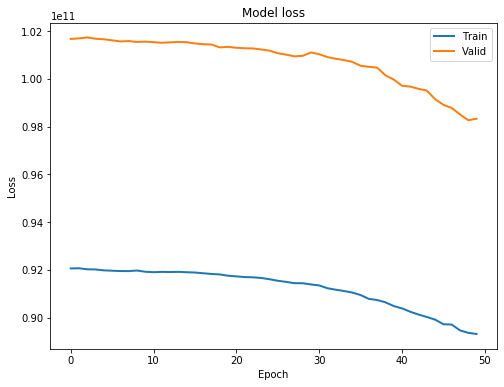

In [47]:
plt.plot(lstm_autoencoder_history['loss'], linewidth=2, label='Train')
plt.plot(lstm_autoencoder_history['val_loss'], linewidth=2, label='Valid')
plt.legend(loc='upper right')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

##### Predicting on X-valid data(both normal and anomaly)

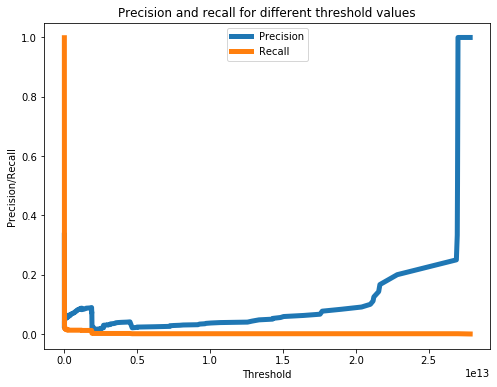

In [48]:
valid_x_predictions = lstm_autoencoder.predict(X_valid)
mse = np.mean(np.power(flatten(X_valid) - flatten(valid_x_predictions), 2), axis=1)

error_df = pd.DataFrame({'Reconstruction_error': mse,
                        'True_class': y_valid.tolist()})

precision_rt, recall_rt, threshold_rt = precision_recall_curve(error_df.True_class, error_df.Reconstruction_error)
plt.plot(threshold_rt, precision_rt[1:], label="Precision",linewidth=5)
plt.plot(threshold_rt, recall_rt[1:], label="Recall",linewidth=5)
plt.title('Precision and recall for different threshold values')
plt.xlabel('Threshold')
plt.ylabel('Precision/Recall')
plt.legend()
plt.show()

##### Predicting on test data(both normal and anomaly)

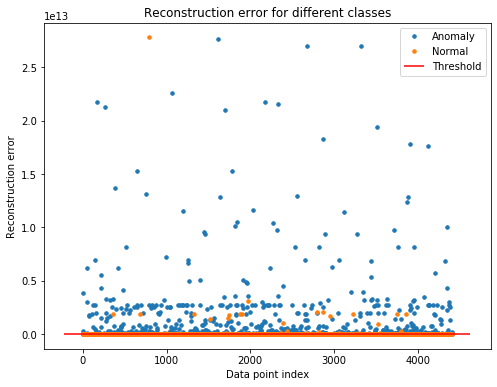

In [49]:
test_x_predictions = lstm_autoencoder.predict(X_test)
mse = np.mean(np.power(flatten(X_test) - flatten(test_x_predictions), 2), axis=1)

error_df = pd.DataFrame({'Reconstruction_error': mse,
                        'True_class': y_test.tolist()})

threshold_fixed = 0.07

groups = error_df.groupby('True_class')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.Reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Normal" if name == 1 else "Anomaly")
ax.hlines(threshold_fixed, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

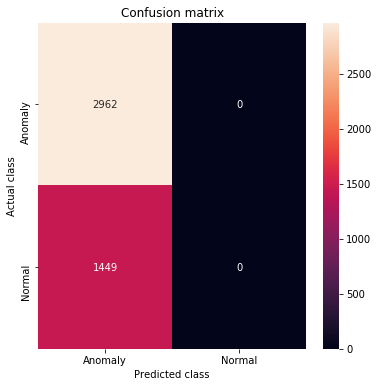

In [50]:
pred_y = [0 if e > threshold_fixed else 1 for e in error_df.Reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.True_class, pred_y)

plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('Actual class')
plt.xlabel('Predicted class')
plt.show()

In [51]:
error_df['True_class'].value_counts() 

0    2962
1    1449
Name: True_class, dtype: int64

##### Classification Report

In [52]:
from sklearn.metrics import classification_report
print(classification_report(y_test, pred_y))

              precision    recall  f1-score   support

           0       0.67      1.00      0.80      2962
           1       0.00      0.00      0.00      1449

    accuracy                           0.67      4411
   macro avg       0.34      0.50      0.40      4411
weighted avg       0.45      0.67      0.54      4411



C:\Users\saranya\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


##### AUC_ROC curve

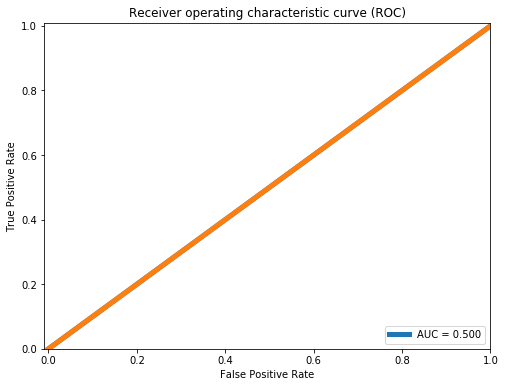

In [53]:
false_pos_rate, true_pos_rate, thresholds = roc_curve(y_test, pred_y)
roc_auc = auc(false_pos_rate, true_pos_rate,)
plt.plot(false_pos_rate, true_pos_rate, linewidth=5, label='AUC = %0.3f'% roc_auc)
plt.plot([0,1],[0,1], linewidth=5)
plt.xlim([-0.01, 1])
plt.ylim([0, 1.01])
plt.legend(loc='lower right')
plt.title('Receiver operating characteristic curve (ROC)')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

##### Predicting only on X_valid_y0(Anomaly data)

In [54]:
X_valid_y0.shape

(2352, 5, 8)

In [55]:
y_valid_0 = [0] * 42

In [56]:
test_x_predictions_0 = lstm_autoencoder.predict(X_valid_y0)
mse = np.mean(np.power(flatten(X_valid_y0) - flatten(test_x_predictions_0), 2), axis=1)

error_df = pd.DataFrame({'Reconstruction_error': mse,
                        'True_class': y_valid_0})

threshold_fixed = 0.07

groups = error_df.groupby('True_class')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.Reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Normal" if name == 1 else "Anomaly")
ax.hlines(threshold_fixed, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

ValueError: arrays must all be same length

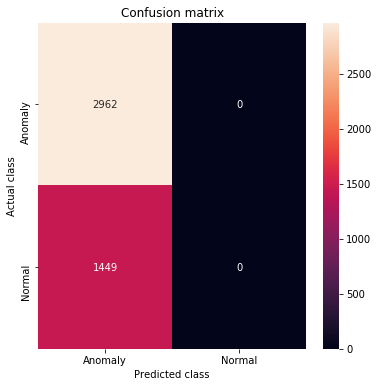

In [57]:
pred_y_0 = [0 if e > threshold_fixed else 1 for e in error_df.Reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.True_class, pred_y_0)

plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('Actual class')
plt.xlabel('Predicted class')
plt.show()